In [3]:
# ## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
# # src: MNIST_Handwritten_Digits_STARTER.ipynb
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn

from MNIST_solver import eval_net_on_data
from  MNIST_solver import create_panel_of_consecutive_ex_images, get_max_n_normalized_mean_n_std
from MNIST_solver import get_train_and_test_data_w_batch_size, MNIST_MLP, eval_net_on_data
from MNIST_solver import PerformanceImprover, TrainingStopper, train_network_classification
from MNIST_solver import define_objective_fcn_with_params, get_HW_acceleration_if_available

# Additional optimizer for tuning the hyper-parameters
# src: https://optuna.org
import optuna
import numpy as np
import torchvision.models as models


#### For Reproducibility

In [2]:
torch_seed = 11
torch.manual_seed(torch_seed)

# Data Loading


In [3]:
data_folder = r'./data'

In [4]:
train_raw = datasets.MNIST(root=data_folder, train=True, download = True, transform=None)
test_raw =  datasets.MNIST(root=data_folder, train=False,download = True, transform=None)

## Now use the non-transformed data, to visualize those


#### Identifying the shapes of our data sets; expecting: (60k, 28, 28) and (10k, 28, 28), for train and test, respectively.

In [5]:
print(f'train shape: {train_raw.data.shape} ; \ntest  shape: {test_raw.data.shape}' )

train shape: torch.Size([60000, 28, 28]) ; 
test  shape: torch.Size([10000, 28, 28])


### Example of visualization

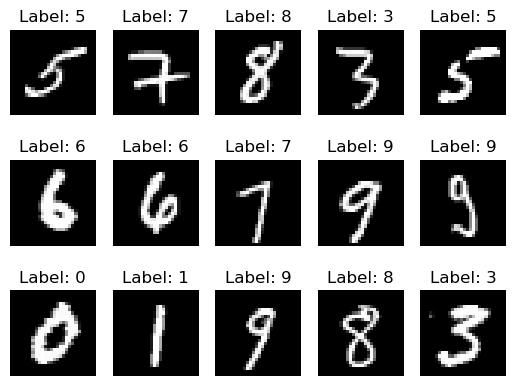

In [6]:
start_idx = 35
panel_dimension = (3,5)
create_panel_of_consecutive_ex_images(start_idx, input_data = train_raw, panel_dims = panel_dimension)

## Create the appropriate transformation pipeline

In [7]:
max_data_value, img_mean, img_std = get_max_n_normalized_mean_n_std(train_raw)
print(f'Max data value: {max_data_value:3.0f}')


print(f'mean: {img_mean.numpy():.4f}; std: {img_std:.4f}') # expected 0.1307 and 0.3081, respectively, 
# according to [1]

Max data value: 255
mean: 0.1307; std: 0.3081


In [8]:
# Define transformation pipeline
transform_pipeline = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((img_mean,), (img_std,))
                               ])

In [9]:
# Transformed data (to be used by the network)
train_data = datasets.MNIST(root=data_folder, train=True,  download = False, transform=transform_pipeline )
test_data =  datasets.MNIST(root=data_folder, train=False, download = False, transform=transform_pipeline)

In [10]:
_, img_rows, img_cols = (train_raw.data.numpy().shape)
network_input_dim = img_rows * img_cols

### Definition of the Neural Network (Non Convolutional)

#### Hyperparameters not optimized (fixed)


In [15]:
BATCH_SIZE = 64
HIDDEN_NODES = (64,64)
LEARNING_RATE = lr=0.00011

In [16]:
# current execution
train_data_loaded , test_data_loaded = get_train_and_test_data_w_batch_size(BATCH_SIZE , train_data, test_data)

# model creation (use CPU: faster for small networks)
model = MNIST_MLP(network_input_dim, HIDDEN_NODES)

# create optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
improver = PerformanceImprover().is_improving

stopping_algo = TrainingStopper(improver)
model, (tr_loss, tr_acc), (val_loss, val_cc)= train_network_classification(model, train_data_loaded, test_data_loaded,optimizer, stopping_algo)


EPOCH: 1
Training Accuracy: 81.9733; Validation Accuracy: 90.8300
EPOCH: 2
Training Accuracy: 91.6133; Validation Accuracy: 92.6900
EPOCH: 3
Training Accuracy: 92.8800; Validation Accuracy: 93.2800
EPOCH: 4
Training Accuracy: 93.7633; Validation Accuracy: 94.2200
EPOCH: 5
Training Accuracy: 94.5600; Validation Accuracy: 94.6600
EPOCH: 6
Training Accuracy: 95.0783; Validation Accuracy: 94.9000
EPOCH: 7
Training Accuracy: 95.5367; Validation Accuracy: 95.4200
EPOCH: 8
Training Accuracy: 95.9500; Validation Accuracy: 95.7200
EPOCH: 9
Training Accuracy: 96.2617; Validation Accuracy: 95.9500
EPOCH: 10
Training Accuracy: 96.5867; Validation Accuracy: 96.1600
EPOCH: 11
Training Accuracy: 96.8117; Validation Accuracy: 96.4300
EPOCH: 12
Training Accuracy: 97.0750; Validation Accuracy: 96.7100
EPOCH: 13
Training Accuracy: 97.2817; Validation Accuracy: 96.7500
EPOCH: 14
Training Accuracy: 97.4867; Validation Accuracy: 96.9000
EPOCH: 15
Training Accuracy: 97.5800; Validation Accuracy: 97.0400
EPOC

In [14]:
eval_net_on_data(test_data_loaded, model,
                     'cpu')  #97.71

(12.57611665470904, tensor(9771))

In [15]:
torch.save(model, 'net_no_hyperparameter_opt.pt')

### Optimize hyperparameters with Optuna

In [16]:
objective_function = define_objective_fcn_with_params(network_input_dim, train_data, test_data)

In [17]:
study = optuna.create_study(direction='maximize')  # Change 'maximize' to 'minimize' for different objectives


[I 2023-10-03 19:01:29,326] A new study created in memory with name: no-name-f6fc7028-6dc4-4e24-a41c-8772be322260


In [18]:
study.optimize(objective_function, n_trials=10)

EPOCH: 1
Training Accuracy: 90.4817; Validation Accuracy: 92.4400
EPOCH: 2
Training Accuracy: 93.2700; Validation Accuracy: 93.0900
EPOCH: 3
Training Accuracy: 93.9583; Validation Accuracy: 93.7100
EPOCH: 4
Training Accuracy: 94.2567; Validation Accuracy: 94.4300
EPOCH: 5
Training Accuracy: 94.4383; Validation Accuracy: 94.0200
EPOCH: 6
Training Accuracy: 94.7283; Validation Accuracy: 94.0600
EPOCH: 7
Training Accuracy: 94.8233; Validation Accuracy: 94.4700
EPOCH: 8
Training Accuracy: 95.0683; Validation Accuracy: 94.8300
EPOCH: 9
Training Accuracy: 95.2767; Validation Accuracy: 94.9600
EPOCH: 10
Training Accuracy: 95.1733; Validation Accuracy: 94.6400
EPOCH: 11
Training Accuracy: 95.3867; Validation Accuracy: 94.8200
EPOCH: 12
Training Accuracy: 95.3533; Validation Accuracy: 94.7500
EPOCH: 13
Training Accuracy: 95.4300; Validation Accuracy: 95.0200
EPOCH: 14
Training Accuracy: 95.4617; Validation Accuracy: 93.6800
EPOCH: 15
Training Accuracy: 95.6017; Validation Accuracy: 94.6100
EPOC

[I 2023-10-03 19:02:37,528] Trial 0 finished with value: 95.02000427246094 and parameters: {'exp_batch_size': 4, 'exp_nodes_1': 5, 'exp_nodes_2': 8, 'lr': 0.004272024171325748}. Best is trial 0 with value: 95.02000427246094.


Training Accuracy: 95.6217; Validation Accuracy: 94.9300
EPOCH: 18
EPOCH: 1
Training Accuracy: 90.3233; Validation Accuracy: 94.9300
EPOCH: 2
Training Accuracy: 95.5433; Validation Accuracy: 96.4400
EPOCH: 3
Training Accuracy: 96.9267; Validation Accuracy: 96.7800
EPOCH: 4
Training Accuracy: 97.6983; Validation Accuracy: 97.3600
EPOCH: 5
Training Accuracy: 98.1800; Validation Accuracy: 98.0000
EPOCH: 6
Training Accuracy: 98.6000; Validation Accuracy: 97.8000
EPOCH: 7
Training Accuracy: 98.8683; Validation Accuracy: 97.8500
EPOCH: 8
Training Accuracy: 99.1300; Validation Accuracy: 97.8300
EPOCH: 9
Training Accuracy: 99.2650; Validation Accuracy: 97.8200
EPOCH: 10
Training Accuracy: 99.4317; Validation Accuracy: 97.9400
EPOCH: 11
Training Accuracy: 99.5550; Validation Accuracy: 98.1400
EPOCH: 12
Training Accuracy: 99.6300; Validation Accuracy: 98.1900
EPOCH: 13
Training Accuracy: 99.6950; Validation Accuracy: 98.2000
EPOCH: 14
Training Accuracy: 99.7133; Validation Accuracy: 97.9700
EPOC

[I 2023-10-03 19:03:56,754] Trial 1 finished with value: 98.19999694824219 and parameters: {'exp_batch_size': 5, 'exp_nodes_1': 8, 'exp_nodes_2': 7, 'lr': 0.0001650614444158607}. Best is trial 1 with value: 98.19999694824219.


Training Accuracy: 99.8683; Validation Accuracy: 98.0400
EPOCH: 20
EPOCH: 1
Training Accuracy: 78.2567; Validation Accuracy: 90.0900
EPOCH: 2
Training Accuracy: 90.4233; Validation Accuracy: 91.9300
EPOCH: 3
Training Accuracy: 91.8700; Validation Accuracy: 92.7100
EPOCH: 4
Training Accuracy: 92.9250; Validation Accuracy: 93.5000
EPOCH: 5
Training Accuracy: 93.6983; Validation Accuracy: 94.0000
EPOCH: 6
Training Accuracy: 94.2767; Validation Accuracy: 94.6200
EPOCH: 7
Training Accuracy: 94.8100; Validation Accuracy: 94.8700
EPOCH: 8
Training Accuracy: 95.2083; Validation Accuracy: 95.2000
EPOCH: 9
Training Accuracy: 95.6367; Validation Accuracy: 95.4200
EPOCH: 10
Training Accuracy: 95.9333; Validation Accuracy: 95.8000
EPOCH: 11
Training Accuracy: 96.2017; Validation Accuracy: 96.0200
EPOCH: 12
Training Accuracy: 96.4583; Validation Accuracy: 96.0500
EPOCH: 13
Training Accuracy: 96.7183; Validation Accuracy: 96.4200
EPOCH: 14
Training Accuracy: 96.9033; Validation Accuracy: 96.5600
EPOC

[I 2023-10-03 19:06:53,585] Trial 2 finished with value: 98.04000091552734 and parameters: {'exp_batch_size': 6, 'exp_nodes_1': 8, 'exp_nodes_2': 5, 'lr': 4.639329832576119e-05}. Best is trial 1 with value: 98.19999694824219.


Training Accuracy: 99.8050; Validation Accuracy: 97.9100
EPOCH: 58
EPOCH: 1
Training Accuracy: 65.7967; Validation Accuracy: 83.7100
EPOCH: 2
Training Accuracy: 85.6817; Validation Accuracy: 88.6300
EPOCH: 3
Training Accuracy: 89.0100; Validation Accuracy: 90.3100
EPOCH: 4
Training Accuracy: 90.2000; Validation Accuracy: 91.0500
EPOCH: 5
Training Accuracy: 90.9417; Validation Accuracy: 91.5800
EPOCH: 6
Training Accuracy: 91.4733; Validation Accuracy: 92.0400
EPOCH: 7
Training Accuracy: 91.8633; Validation Accuracy: 92.4000
EPOCH: 8
Training Accuracy: 92.1717; Validation Accuracy: 92.7800
EPOCH: 9
Training Accuracy: 92.4400; Validation Accuracy: 92.8800
EPOCH: 10
Training Accuracy: 92.6450; Validation Accuracy: 93.0100
EPOCH: 11
Training Accuracy: 92.9017; Validation Accuracy: 93.1700
EPOCH: 12
Training Accuracy: 93.0750; Validation Accuracy: 93.3000
EPOCH: 13
Training Accuracy: 93.2950; Validation Accuracy: 93.3600
EPOCH: 14
Training Accuracy: 93.4900; Validation Accuracy: 93.4100
EPOC

[I 2023-10-03 19:13:45,414] Trial 3 finished with value: 96.36000061035156 and parameters: {'exp_batch_size': 4, 'exp_nodes_1': 4, 'exp_nodes_2': 7, 'lr': 1.9283450061210374e-05}. Best is trial 1 with value: 98.19999694824219.


Training Accuracy: 97.6267; Validation Accuracy: 96.3500
EPOCH: 115
EPOCH: 1
Training Accuracy: 82.8450; Validation Accuracy: 91.7200
EPOCH: 2
Training Accuracy: 92.5167; Validation Accuracy: 93.4300
EPOCH: 3
Training Accuracy: 93.6733; Validation Accuracy: 94.0700
EPOCH: 4
Training Accuracy: 94.2750; Validation Accuracy: 94.6400
EPOCH: 5
Training Accuracy: 94.9300; Validation Accuracy: 95.1300
EPOCH: 6
Training Accuracy: 95.2383; Validation Accuracy: 95.2400
EPOCH: 7
Training Accuracy: 95.5517; Validation Accuracy: 95.3100
EPOCH: 8
Training Accuracy: 95.8550; Validation Accuracy: 95.5800
EPOCH: 9
Training Accuracy: 95.9983; Validation Accuracy: 95.7600
EPOCH: 10
Training Accuracy: 96.2000; Validation Accuracy: 95.6200
EPOCH: 11
Training Accuracy: 96.3517; Validation Accuracy: 95.8000
EPOCH: 12
Training Accuracy: 96.5517; Validation Accuracy: 95.8000
EPOCH: 13
Training Accuracy: 96.6500; Validation Accuracy: 95.8000
EPOCH: 14
Training Accuracy: 96.7633; Validation Accuracy: 96.0300
EPO

[I 2023-10-03 19:14:58,939] Trial 4 finished with value: 96.26000213623047 and parameters: {'exp_batch_size': 7, 'exp_nodes_1': 4, 'exp_nodes_2': 5, 'lr': 0.0006932694002964431}. Best is trial 1 with value: 98.19999694824219.


Training Accuracy: 97.6800; Validation Accuracy: 96.0800
EPOCH: 31
EPOCH: 1
Training Accuracy: 51.6217; Validation Accuracy: 76.1200
EPOCH: 2
Training Accuracy: 82.5150; Validation Accuracy: 86.5000
EPOCH: 3
Training Accuracy: 87.0117; Validation Accuracy: 88.9100
EPOCH: 4
Training Accuracy: 88.7967; Validation Accuracy: 89.8700
EPOCH: 5
Training Accuracy: 89.6100; Validation Accuracy: 90.3800
EPOCH: 6
Training Accuracy: 90.1433; Validation Accuracy: 90.6100
EPOCH: 7
Training Accuracy: 90.5600; Validation Accuracy: 90.8200
EPOCH: 8
Training Accuracy: 90.8367; Validation Accuracy: 91.1800
EPOCH: 9
Training Accuracy: 91.1133; Validation Accuracy: 91.2300
EPOCH: 10
Training Accuracy: 91.3367; Validation Accuracy: 91.5300
EPOCH: 11
Training Accuracy: 91.4900; Validation Accuracy: 91.6300
EPOCH: 12
Training Accuracy: 91.6767; Validation Accuracy: 91.8700
EPOCH: 13
Training Accuracy: 91.8433; Validation Accuracy: 91.9200
EPOCH: 14
Training Accuracy: 92.0133; Validation Accuracy: 92.1400
EPOC

Training Accuracy: 96.1617; Validation Accuracy: 95.3900
EPOCH: 123
Training Accuracy: 96.2117; Validation Accuracy: 95.3000
EPOCH: 124
Training Accuracy: 96.2350; Validation Accuracy: 95.4000
EPOCH: 125
Training Accuracy: 96.2317; Validation Accuracy: 95.3000
EPOCH: 126
Training Accuracy: 96.2067; Validation Accuracy: 95.3500
EPOCH: 127
Training Accuracy: 96.2067; Validation Accuracy: 95.3700
EPOCH: 128
Training Accuracy: 96.2483; Validation Accuracy: 95.3200
EPOCH: 129
Training Accuracy: 96.2583; Validation Accuracy: 95.4200
EPOCH: 130
Training Accuracy: 96.2783; Validation Accuracy: 95.3800
EPOCH: 131
Training Accuracy: 96.2983; Validation Accuracy: 95.4300
EPOCH: 132
Training Accuracy: 96.2967; Validation Accuracy: 95.4100
EPOCH: 133
Training Accuracy: 96.3050; Validation Accuracy: 95.4600
EPOCH: 134
Training Accuracy: 96.3667; Validation Accuracy: 95.4700
EPOCH: 135
Training Accuracy: 96.3367; Validation Accuracy: 95.4400
EPOCH: 136
Training Accuracy: 96.3883; Validation Accuracy:

Training Accuracy: 97.1883; Validation Accuracy: 95.7200
EPOCH: 244
Training Accuracy: 97.1850; Validation Accuracy: 95.6500
EPOCH: 245
Training Accuracy: 97.1633; Validation Accuracy: 95.7000
EPOCH: 246
Training Accuracy: 97.1967; Validation Accuracy: 95.6900
EPOCH: 247
Training Accuracy: 97.1967; Validation Accuracy: 95.6500
EPOCH: 248
Training Accuracy: 97.2117; Validation Accuracy: 95.6700
EPOCH: 249
Training Accuracy: 97.1933; Validation Accuracy: 95.6700
EPOCH: 250
Training Accuracy: 97.1933; Validation Accuracy: 95.7400
EPOCH: 251
Training Accuracy: 97.2067; Validation Accuracy: 95.6900
EPOCH: 252
Training Accuracy: 97.1883; Validation Accuracy: 95.6200
EPOCH: 253
Training Accuracy: 97.2017; Validation Accuracy: 95.6800
EPOCH: 254
Training Accuracy: 97.1933; Validation Accuracy: 95.7000
EPOCH: 255
Training Accuracy: 97.2233; Validation Accuracy: 95.6900
EPOCH: 256
Training Accuracy: 97.2100; Validation Accuracy: 95.7200
EPOCH: 257
Training Accuracy: 97.2617; Validation Accuracy:

[I 2023-10-03 19:37:00,889] Trial 5 finished with value: 95.77999877929688 and parameters: {'exp_batch_size': 3, 'exp_nodes_1': 4, 'exp_nodes_2': 5, 'lr': 1.2453071763189483e-05}. Best is trial 1 with value: 98.19999694824219.


Training Accuracy: 97.3133; Validation Accuracy: 95.7200
EPOCH: 273
EPOCH: 1
Training Accuracy: 86.0600; Validation Accuracy: 92.4000
EPOCH: 2
Training Accuracy: 93.9000; Validation Accuracy: 95.4500
EPOCH: 3
Training Accuracy: 95.7967; Validation Accuracy: 96.3600
EPOCH: 4
Training Accuracy: 96.6950; Validation Accuracy: 96.1000
EPOCH: 5
Training Accuracy: 97.4100; Validation Accuracy: 97.2700
EPOCH: 6
Training Accuracy: 97.9583; Validation Accuracy: 97.4600
EPOCH: 7
Training Accuracy: 98.2617; Validation Accuracy: 97.5300
EPOCH: 8
Training Accuracy: 98.5333; Validation Accuracy: 97.4700
EPOCH: 9
Training Accuracy: 98.7967; Validation Accuracy: 97.4300
EPOCH: 10
Training Accuracy: 98.9517; Validation Accuracy: 97.8400
EPOCH: 11
Training Accuracy: 99.1567; Validation Accuracy: 97.5600
EPOCH: 12
Training Accuracy: 99.2400; Validation Accuracy: 97.8200
EPOCH: 13
Training Accuracy: 99.4250; Validation Accuracy: 97.6500
EPOCH: 14
Training Accuracy: 99.5017; Validation Accuracy: 97.9200
EPO

[I 2023-10-03 19:37:50,665] Trial 6 finished with value: 97.91999816894531 and parameters: {'exp_batch_size': 10, 'exp_nodes_1': 7, 'exp_nodes_2': 6, 'lr': 0.0026159038831232734}. Best is trial 1 with value: 98.19999694824219.


Training Accuracy: 99.7217; Validation Accuracy: 97.8700
EPOCH: 22
EPOCH: 1
Training Accuracy: 35.1033; Validation Accuracy: 53.3200
EPOCH: 2
Training Accuracy: 59.8267; Validation Accuracy: 71.2200
EPOCH: 3
Training Accuracy: 75.5150; Validation Accuracy: 81.6500
EPOCH: 4
Training Accuracy: 82.1467; Validation Accuracy: 84.9600
EPOCH: 5
Training Accuracy: 85.0867; Validation Accuracy: 86.9900
EPOCH: 6
Training Accuracy: 86.7250; Validation Accuracy: 88.2900
EPOCH: 7
Training Accuracy: 88.0400; Validation Accuracy: 88.9100
EPOCH: 8
Training Accuracy: 88.8750; Validation Accuracy: 89.7400
EPOCH: 9
Training Accuracy: 89.4683; Validation Accuracy: 90.1000
EPOCH: 10
Training Accuracy: 90.0583; Validation Accuracy: 90.6100
EPOCH: 11
Training Accuracy: 90.4350; Validation Accuracy: 90.9900
EPOCH: 12
Training Accuracy: 90.7617; Validation Accuracy: 91.1600
EPOCH: 13
Training Accuracy: 91.0600; Validation Accuracy: 91.4800
EPOCH: 14
Training Accuracy: 91.4283; Validation Accuracy: 91.7600
EPOC

Training Accuracy: 97.3283; Validation Accuracy: 96.3700
EPOCH: 123
Training Accuracy: 97.3567; Validation Accuracy: 96.4300
EPOCH: 124
Training Accuracy: 97.3583; Validation Accuracy: 96.4000
EPOCH: 125
Training Accuracy: 97.3850; Validation Accuracy: 96.3400
EPOCH: 126
Training Accuracy: 97.3833; Validation Accuracy: 96.3900
EPOCH: 127
Training Accuracy: 97.3983; Validation Accuracy: 96.3700
EPOCH: 128
Training Accuracy: 97.4017; Validation Accuracy: 96.3500
EPOCH: 129
Training Accuracy: 97.4350; Validation Accuracy: 96.3800
EPOCH: 130
Training Accuracy: 97.4083; Validation Accuracy: 96.3500
EPOCH: 131
Training Accuracy: 97.4317; Validation Accuracy: 96.4000
EPOCH: 132
Training Accuracy: 97.4700; Validation Accuracy: 96.3400
EPOCH: 133
Training Accuracy: 97.5017; Validation Accuracy: 96.4300
EPOCH: 134
Training Accuracy: 97.4750; Validation Accuracy: 96.4200
EPOCH: 135
Training Accuracy: 97.5083; Validation Accuracy: 96.4600
EPOCH: 136
Training Accuracy: 97.5233; Validation Accuracy:

[I 2023-10-03 19:45:28,479] Trial 7 finished with value: 96.80000305175781 and parameters: {'exp_batch_size': 8, 'exp_nodes_1': 5, 'exp_nodes_2': 4, 'lr': 5.6987196279944157e-05}. Best is trial 1 with value: 98.19999694824219.


Training Accuracy: 98.1617; Validation Accuracy: 96.8000
EPOCH: 194
EPOCH: 1
Training Accuracy: 76.7917; Validation Accuracy: 90.3900
EPOCH: 2
Training Accuracy: 90.8667; Validation Accuracy: 91.9200
EPOCH: 3
Training Accuracy: 92.2600; Validation Accuracy: 93.1600
EPOCH: 4
Training Accuracy: 93.2100; Validation Accuracy: 93.5000
EPOCH: 5
Training Accuracy: 94.0600; Validation Accuracy: 94.2400
EPOCH: 6
Training Accuracy: 94.7250; Validation Accuracy: 94.8200
EPOCH: 7
Training Accuracy: 95.2450; Validation Accuracy: 95.2000
EPOCH: 8
Training Accuracy: 95.7333; Validation Accuracy: 95.7300
EPOCH: 9
Training Accuracy: 96.1583; Validation Accuracy: 96.1700
EPOCH: 10
Training Accuracy: 96.5083; Validation Accuracy: 96.2200
EPOCH: 11
Training Accuracy: 96.7383; Validation Accuracy: 96.4000
EPOCH: 12
Training Accuracy: 97.0100; Validation Accuracy: 96.6500
EPOCH: 13
Training Accuracy: 97.2200; Validation Accuracy: 96.7200
EPOCH: 14
Training Accuracy: 97.3617; Validation Accuracy: 96.9000
EPO

[I 2023-10-03 19:47:05,493] Trial 8 finished with value: 97.79000091552734 and parameters: {'exp_batch_size': 9, 'exp_nodes_1': 6, 'exp_nodes_2': 7, 'lr': 0.0003540491634685089}. Best is trial 1 with value: 98.19999694824219.


Training Accuracy: 99.5317; Validation Accuracy: 97.7900
EPOCH: 42
EPOCH: 1
Training Accuracy: 87.3400; Validation Accuracy: 92.8200
EPOCH: 2
Training Accuracy: 93.4200; Validation Accuracy: 94.5400
EPOCH: 3
Training Accuracy: 94.9933; Validation Accuracy: 95.5600
EPOCH: 4
Training Accuracy: 96.0267; Validation Accuracy: 96.1700
EPOCH: 5
Training Accuracy: 96.8083; Validation Accuracy: 96.6000
EPOCH: 6
Training Accuracy: 97.3200; Validation Accuracy: 97.1500
EPOCH: 7
Training Accuracy: 97.6900; Validation Accuracy: 97.2600
EPOCH: 8
Training Accuracy: 98.0317; Validation Accuracy: 97.5500
EPOCH: 9
Training Accuracy: 98.3467; Validation Accuracy: 97.6200
EPOCH: 10
Training Accuracy: 98.5350; Validation Accuracy: 97.6400
EPOCH: 11
Training Accuracy: 98.7650; Validation Accuracy: 97.7400
EPOCH: 12
Training Accuracy: 98.9050; Validation Accuracy: 97.7100
EPOCH: 13
Training Accuracy: 99.0750; Validation Accuracy: 97.9800
EPOCH: 14
Training Accuracy: 99.1583; Validation Accuracy: 98.0000
EPOC

[I 2023-10-03 19:50:31,886] Trial 9 finished with value: 98.18000030517578 and parameters: {'exp_batch_size': 4, 'exp_nodes_1': 8, 'exp_nodes_2': 8, 'lr': 3.93780108452207e-05}. Best is trial 1 with value: 98.19999694824219.


Training Accuracy: 99.9817; Validation Accuracy: 98.0800
EPOCH: 33


In [21]:
best_trial = study.best_trial
best_trial.value # this should be 98.2%

98.19999694824219

In [22]:
best_trial.params

{'exp_batch_size': 5,
 'exp_nodes_1': 8,
 'exp_nodes_2': 7,
 'lr': 0.0001650614444158607}

In [23]:
get_exp_at_level = lambda index: 2**best_trial.params['exp_nodes_' + str(index)] 

hidden_nodes = get_exp_at_level(1), get_exp_at_level(2)

model = MNIST_MLP(network_input_dim, hidden_nodes )

In [24]:
model.load_state_dict(best_trial.user_attrs.get("best_state_dict"))

<All keys matched successfully>

In [25]:
eval_net_on_data(test_data_loaded, model,
                     'cpu') # expexted 9820; i.e.: 98.20%

(10.040427794664538, tensor(9820))

In [26]:
torch.save(model, 'net_w_hyperparameter_opt.pt')

### Get use of HW acceleration, if available


In [23]:
device = get_HW_acceleration_if_available()
print(f"Device used: {device}")

NameError: name 'get_HW_acceleration_if_available' is not defined

### Try with Resnet

In [13]:
# Load a pre-trained ResNet-18 model
resnet = models.resnet18(weights='ResNet18_Weights.DEFAULT')

In [14]:
network_input_dim

784

In [15]:
BATCH_SIZE = 64 # not optimized this time

In [16]:
# Modify the first convolutional layer to accept 1 input channel
# The original input channels were 3 (RGB), change it to 1
resnet.conv1 = nn.Conv2d(1, BATCH_SIZE, kernel_size=7, stride=2, padding=3, bias=False)

In [17]:
num_classes = 10  # MNIST has 10 classes (digits 0-9)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

In [18]:
resnet.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
from MNIST_solver import get_model_device

In [23]:
get_model_device(resnet)
train_loss_history, training_acc_hist = list(), list()
val_loss_history, val_acc_hist = list(), list()
num_train_samples = len(train_loader.dataset)
num_val_samples = len(test_loader.dataset)
best_test_accuracy = 0.0
best_net_weights = resnet.state_dict()

In [2]:
from MNIST_solver import train_net_on_data

In [27]:
optimizer = optim.Adam(resnet.parameters(), lr= 0.00045)

In [30]:
device
import torch.nn.functional as F
criterion=F.cross_entropy

In [3]:
training_loss, num_corrected_samples_train = \
            train_net_on_data(train_loader, optimizer, resnet, device, criterion)

NameError: name 'train_loader' is not defined

In [25]:
improver = PerformanceImprover().is_improving
stopping_algo = TrainingStopper(improver)

# I should simply add a 'reset' method somewhere.

In [6]:
train_loader, test_loader = get_train_and_test_data_w_batch_size(BATCH_SIZE, train_data, test_data)

NameError: name 'BATCH_SIZE' is not defined

NameError: name 'train_loader' is not defined

In [27]:
from MNIST_solver import train_network_classification

In [ ]:
%%time
import torch.nn.functional as F

train_network_classification(resnet, train_data_loaded, test_data_loaded,  optim.Adam(resnet.parameters(), lr= 0.00045), stopping_algo)
# train_network_classification(resnet, train_data_loaded, test_data_loaded, optimizer, stopping_algo)

EPOCH: 1
